# Constrained Food Recommender

In this assignment, you will implement both Content Based and Collaborative Filtering Recommenders and backtracking search (or local search) on your own

100% finished homework should contain EDA, Item and User profiles generation, Content-Based Recommender, Collaborative Filtering Recommender, and soluton to CSP problem of assigning recommendations to brekfast, lunch and dinner.

In [117]:
from tqdm import tqdm

import json
import folium
import pandas as pd
import numpy as np
import folium.plugins as plg


import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
# Apply plot style.
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15,7)

# allow full-size pandas.head
pd.options.display.max_columns = None

## Data loading

You will work with subset of [Academic Yelp Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset) containing list of restaurants in **yelp_business.csv** and reviews of the users in **yelp_reviews.parquet**

In [305]:
import pandas as pd

df_yelp_business = pd.read_csv("yelp_business.csv").drop(columns=["Unnamed: 0"])
df_yelp_reviews = pd.read_parquet("yelp_reviews.parquet")

# Leave only users with at least 3 reviews
users_count = df_yelp_reviews.groupby("user_id").count()[["business_id"]] 
users_to_use = users_count[users_count["business_id"] > 2]
df_yelp_reviews = df_yelp_reviews[df_yelp_reviews["user_id"].isin(users_to_use.index)]

## Exploratory data analysis

Here you will explore the data to find out what is the distribution of business categories, hours, places, user reviews, etc.

This step is needed to proceed later with item and user profiling and to clean your data if there are duplicates (e.g. duplicated reviews, the same businesses under different ids, categories tags which are highly correlated) or some artifacts not related to the main task.

(5 points)

In [2]:
df_yelp_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,404 E Green St,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...",pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,5,4.5,IL
1,4508 E Independence Blvd,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...",CsLQLiRoafpJPJSkNX2h5Q,"Food, Restaurants, Grocery, Middle Eastern",Charlotte,NaN,0,35.194894,-80.767442,Middle East Deli,28205,5,3.0,NC
2,300 John Street,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",Thornhill,NaN,1,43.820492,-79.398466,Banzai Sushi,L3T 5W4,7,4.5,ON
3,"4550 East Cactus Rd, #KSFC-4","{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",vjTVxnsQEZ34XjYNS-XUpA,"Food, Pretzels, Bakeries, Fast Food, Restaurants",Phoenix,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",1,33.602822,-111.983533,Wetzel's Pretzels,85032,10,4.0,AZ
4,9595 W Tropicana Ave,"{'Alcohol': ""u'none'"", 'WiFi': ""u'no'"", 'GoodF...",fnZrZlqW1Z8iWgTVDfv_MA,"Mexican, Restaurants, Fast Food",Las Vegas,NaN,0,36.099738,-115.301568,Carl's Jr,89147,15,2.5,NV


In [3]:
df_yelp_reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
4,IS4cv902ykd8wj1TR0N3-A,0,2017-01-14 21:56:57,0,6TdNDKywdbjoTkizeMce8A,4,happy day finally canes near casa yes others g...,0,UgMW8bLE0QMJDCkQ1Ax5Mg
6,Pthe4qk5xh4n-ef-9bvMSg,0,2015-11-05 23:11:05,0,ZayJ1zWyWgY9S_TRLT_y9Q,5,really good place simple decor amazing food gr...,1,aq_ZxGHiri48TUXJlpRkCQ
9,Ws8V970-mQt2X9CwCuT5zw,1,2009-10-13 04:16:41,0,z4BCgTkfNtCu4XY5Lp97ww,4,twice nice laid back tried weekend southern me...,3,jOERvhmK6_lo_XGUBPws_w
16,d4qwVw4PcN-_2mK2o1Ro1g,0,2015-02-02 06:28:00,0,bVTjZgRNq8ToxzvtiVrqMA,1,10pm super bowl sunday already closed weak won...,0,2hRe26HSCAWbFRn5WChK-Q
22,9Jo1pu0y2zU6ktiwQm6gNA,20,2016-12-04 03:15:21,19,sgTnHfeaEvyOoWX4TCgkuQ,4,coconut fish cafe fantastic five stars fish ca...,24,A0j21z2Q1HGic7jW6e9h7A


## Inspect Categories

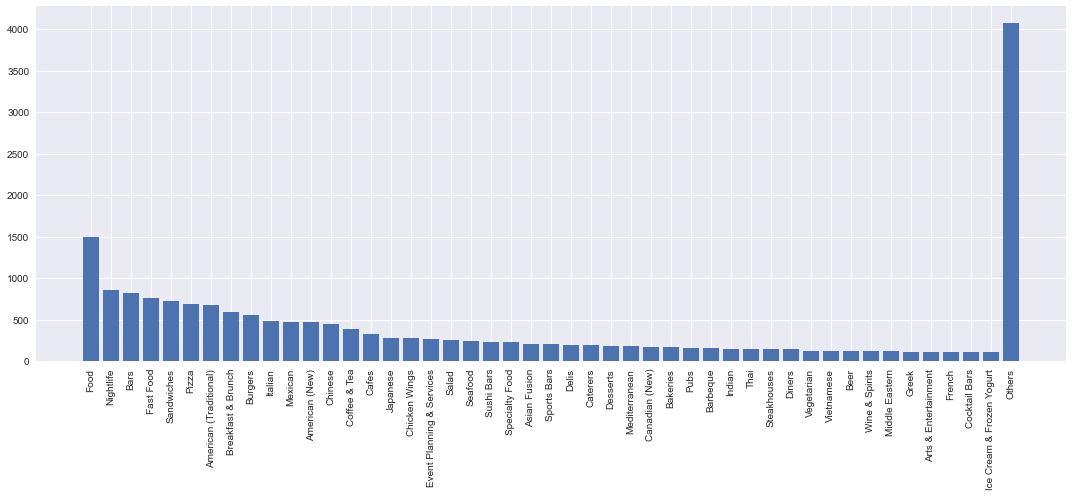

In [49]:
# get categories
categories = df_yelp_business[["categories"]]
categories_dict = {}
# count the number of times each category is listed
for index, cats in categories.iterrows():
    splited_cats = cats.str.split(", ")
    # add category to dict
    for category in splited_cats[0]:
        if not category in categories_dict.keys():
            categories_dict[category] = 1
        else:
            categories_dict[category] += 1
            
# sort categories by number of occurences in the desc order
category_counts = list(categories_dict.items())
category_counts.sort(key=lambda x: x[1], reverse=True)

# create a list of categories that have > 100 occurences
# the rest percieve as others
top_categories, top_counts = [], []
others_count = 0
for category, count in category_counts:
    if count > 100:
        top_categories.append(category) 
        top_counts.append(count)
    else:
        others_count += count
        
# plot to categories
plt.bar((top_categories + ["Others"])[1:], (top_counts + [others_count])[1:])
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()
    
# print the category and its count
# for category, count in category_counts:
#     print(f"{category}: {count}")

## Inspect Locations

In [89]:
# get reataurant locations
locations = list(zip(df_yelp_business.latitude.tolist(), df_yelp_business.longitude.tolist()))

# create a world map
loc_map = folium.Map()
# add markers of locations
markers = plg.MarkerCluster(locations=locations)  
loc_map.add_child(markers)
# show map
loc_map

In [94]:
# get all unique states
states = df_yelp_business.state.unique()
states = pd.DataFrame(states, columns=["States"])
states

,States
0,IL
1,NC
2,ON
3,AZ
4,NV
5,QC
6,OH
7,PA
8,AB
9,SC


### Inspect Review Distributions

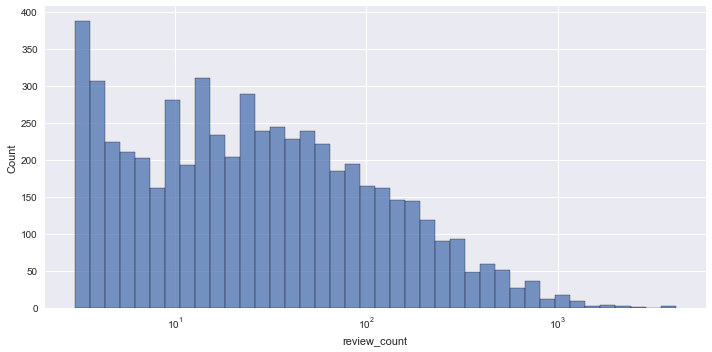

In [96]:
sns.displot(df_yelp_business, x='review_count', kind='hist', aspect=2, log_scale=10, bins=40)

### Inspect Stars Distribution

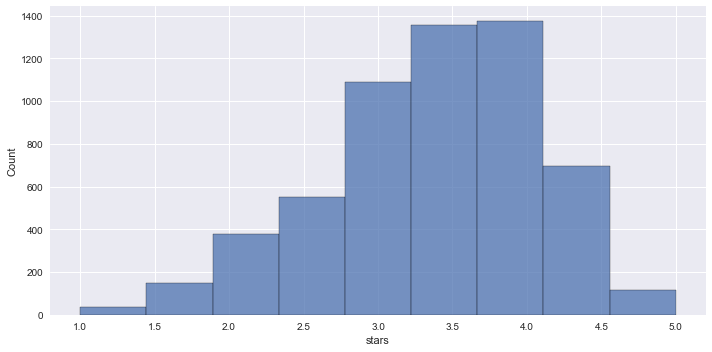

In [97]:
sns.displot(df_yelp_business, x='stars', kind='hist', aspect=2, bins=9)

### Inspect Hours Distribution

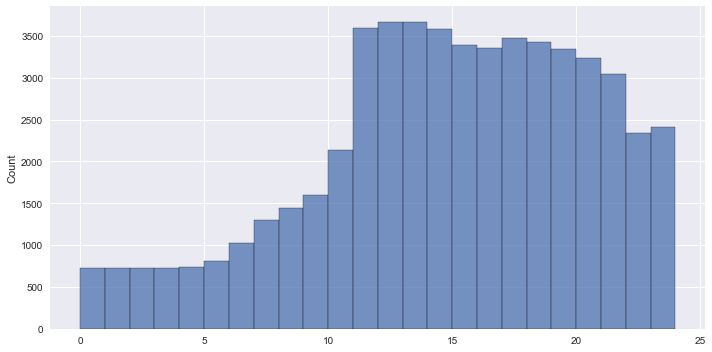

In [115]:
# get all the hours. filter them to be not nan.
hours = df_yelp_business['hours'].to_frame()
hours = hours[hours['hours'].notnull()]

hours_dict = dict()
for hours in hours['hours'].tolist():
    hours_json = json.loads(hours.replace("'", "\""))

    for day_hours in hours_json.items():
        open_hour, close_hour = int(day_hours[1].split('-')[0].split(':')[0]), int(day_hours[1].split('-')[1].split(':')[0])

        # get the closing hour
        if close_hour == 0:
            close_hour = 24
        if close_hour - open_hour < 0:
            close_hour += 12
        # add hours to dict
        if day_hours[0] in hours_dict:
            hours_dict[day_hours[0]] += list(range(open_hour, close_hour + 1))
        else:
            hours_dict[day_hours[0]] = list(range(open_hour, close_hour + 1))
                  
sns.displot(hours_dict['Monday'], kind='hist', aspect=2, bins=24)

## Building recommender

First of all you should process user reviews to get the utility matrix containing ratings for users and businesses. There will be a lot of 0 in this matrix and it is better to store such matrices in the specialized data structure for sparce matrices. However, your working dataset is relatively small and we can use simple **pd.DataFrame** to proceed

This approach is taken from this [acticle (page 19)](http://infolab.stanford.edu/~ullman/mmds/ch9.pdf).

In [122]:
def create_utility_matrix(reviews: pd.DataFrame, business: pd.DataFrame) -> pd.DataFrame:
    business_ids = business["business_id"].unique()
    users = reviews["user_id"].unique()
    ut_matrix = pd.DataFrame(0, columns=business_ids, index=users)
    for _, review in reviews.iterrows():
        ut_matrix.loc[review["user_id"], review["business_id"]] = review["stars"]
        
    # filter zeros to not count in the mean
    ut_matrix_norm = ut_matrix.replace(0, np.nan)
    ut_matrix_norm = ut_matrix_norm.astype(pd.SparseDtype("float", np.nan))
    
    # normalize rows by subtracting an average user review for all businesses 
    ut_matrix_norm = ut_matrix_norm.sub(ut_matrix_norm.mean(axis=1), axis=0)
    
    # normalize columns by subtracting an average review for this business
    ut_matrix_norm = ut_matrix_norm.sub(ut_matrix_norm.mean(axis=0), axis=1)
    
    # Current values are in (-4, 4) range because of double subtraction
    # That is why we can divide all values by 4
    ut_matrix_norm /= 4

    return ut_matrix_norm

df_utility_matrix = create_utility_matrix(df_yelp_reviews, df_yelp_business)

/Users/yar.mor/Library/Python/3.6/lib/python/site-packages/pandas/core/arrays/sparse/array.py:1307: RuntimeWarning: invalid value encountered in double_scalars
  return sp_sum / ct


In [123]:
df_utility_matrix[1:10 :]

,pQeaRpvuhoEqudo3uymHIQ,CsLQLiRoafpJPJSkNX2h5Q,lu7vtrp_bE9PnxWfA8g4Pg,vjTVxnsQEZ34XjYNS-XUpA,fnZrZlqW1Z8iWgTVDfv_MA,rVBPQdeayMYht4Uv_FOLHg,fhNf_sg-XzZ3e7HEVGuOZg,LoRef3ChgZKbxUio-sHgQg,Ga2Bt7xfqoggTypWD5VpoQ,xFc50drSPxXkcLvX5ygqrg,...,2SfSzEd3B7WimeZac23zhg,1dV3qNEv8nNUAX1k3qdE2w,YHCseOJ93wJh0gBcii_2qA,TJt1W9haRm2DKuoZLQ69yA,wM8QNs7uSyDqMJKjBYFPCQ,gp_bu7Ah81qaBY3M0Leffw,PUKOr5bEI87TVHjwijT1xw,zV38gkkEeJ4cVRlSWWQTfQ,H1j34TgbrVZkxeww9xlJTw,F8M0IukXQqR50IRyocRQbg
aq_ZxGHiri48TUXJlpRkCQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jOERvhmK6_lo_XGUBPws_w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2hRe26HSCAWbFRn5WChK-Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0j21z2Q1HGic7jW6e9h7A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XivuRnPq3D-K5cPiBTztIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H3wPBzQCKCKiHcV7GZK4kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6UR0kNe3C-ivlF2x1fPHNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FmQxARdHGnkclvcVWGEAxw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fVILhIglx6RNOXQba5t4kQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
print(f"Max: {df_utility_matrix.fillna(0).values.max()}\nMin: {df_utility_matrix.fillna(0).values.min()}")

Max: 0.8824404761904762
Min: -0.9244434517310335


## Prepare New Features

In [213]:
top10_categories = top_categories[:10]
top10_attributes = [
    'RestaurantsTakeOutTrue', 
    'RestaurantsGoodForGroupsTrue', 
    'GoodForKidsTrue',        
    'BusinessAcceptsCreditCardsTrue', 
    'BikeParkingTrue', 
    'OutdoorSeatingTrue', 
    'RestaurantsReservationsTrue', 
    'lunchTrue', 
    'WiFiufree', 
    'lunchTrue'
]

In [286]:
def get_open_hours(business):
    # get time ranges for breakfast, lunch and dinner
    breakfast_hours, lunch_hours, dinner_hours = set(range(0, 11)), set(range(11, 17)), set(range(17, 25))

    # initial encoding doesn't include any of time ranges.
    encoding = [0, 0, 0]

    # get all the hours. filter them to be not nan.
    open_hours = business['hours']
    
    if open_hours is np.nan:
        return encoding
    
    # convert json to dict
    open_hours = json.loads(open_hours.replace("'", "\""))

    for day_hours in open_hours.items():
        open_hour, close_hour = int(day_hours[1].split('-')[0].split(':')[0]), int(day_hours[1].split('-')[1].split(':')[0])
        
        # get the closing hour
        if close_hour == 0:
            close_hour = 24
        if close_hour - open_hour < 0:
            close_hour += 12

        open_range = list(range(open_hour, close_hour + 1))

        if not breakfast_hours.isdisjoint(open_range):
            encoding[0] += 1
        if not lunch_hours.isdisjoint(open_range):
            encoding[1] += 1
        if not dinner_hours.isdisjoint(open_range):
            encoding[2] += 1
                
    # normalize result
    encoding = np.array(encoding)
    if np.sum(encoding) != 0:
        encoding = encoding / np.sqrt(np.sum(encoding**2))
    
    return list(encoding)

In [255]:
def flatten_attributes(attributes) -> str:
    return str(attributes) \
            .replace("': \"{'", '').replace("}\", '", '').replace('\': "', '').replace('\': \'', '') \
            .replace('"', '').replace("'", '').replace(": ", '').replace("{", '').replace("}", '')


def get_attributes(business: pd.DataFrame) -> list:
    # get all the attributes. filter them to be not nan.
    attributes = business['attributes']
    # attributes = attributes['attributes'].fillna("NULL").to_frame()
    
    # flatten attributes in a single list
    # attributes['attributes'] = attributes[['attributes']].apply(, axis=1)
    flattened_attributes = flatten_attributes(attributes)
    
    # get all the categories. filter them to be not nan.
    categories = business['categories']
    # categories = categories['categories'].fillna("NULL").to_numpy()
    
    # concat categories and attributes.
    new_attributes = categories + ", " + flattened_attributes
    new_attributes = new_attributes.replace(", ", '|').replace(" ", '').replace("...", '|').split("|")
    
    # take only those new attributes that itersect with top10 categories & attributes
    new_attributes = list(set(new_attributes) & set(top10_categories + top10_attributes))
    
    # join new attributes in a single string
    new_attributes = ", ".join(new_attributes)
    return new_attributes

### Apply TF-IDF

In [308]:
from sklearn.feature_extraction.text import TfidfVectorizer


# generate a list of documents
attributes = list(map(lambda x: x[0], df_yelp_business.apply(lambda x : pd.Series(get_attributes(x)), axis=1).values))

# create the vectorizer, tokenize and build vocabulary
vectorizer = TfidfVectorizer(analyzer='word', norm='l2')
vectorizer.fit(attributes)

TfidfVectorizer()

In [309]:
# summarize
print(f'Vocabulary:\n\tLenght:{len(vectorizer.vocabulary_)}\n\tWeights:\n{vectorizer.vocabulary_}\n')
print(f'IDF:\n\tLength:{len(vectorizer.idf_)}\n\tidf:\n{vectorizer.idf_}\n')

# encode document
print(f'Example: {attributes[0]}')
vector = vectorizer.transform([attributes[0]])

# summarize encoded vector
print(f'Vector Shape: {vector.shape}\nVector:\n{vector.toarray()}')

Vocabulary:
	Lenght:16
	Weights:
{'food': 4, 'businessacceptscreditcardstrue': 3, 'restaurants': 10, 'restaurantstakeouttrue': 13, 'restaurantsgoodforgroupstrue': 11, 'goodforkidstrue': 5, 'bikeparkingtrue': 1, 'burgers': 2, 'outdoorseatingtrue': 8, 'restaurantsreservationstrue': 12, 'pizza': 9, 'lunchtrue': 6, 'wifiufree': 15, 'sandwiches': 14, 'bars': 0, 'nightlife': 7}

IDF:
	Length:16
	idf:
[2.94018643 1.86072323 3.33781309 1.66688183 2.34823841 1.47842304
 2.32375819 2.90451083 2.1911259  3.12590358 1.         1.43476477
 2.2242974  1.31085094 3.07198981 2.61449503]

Example: Food, BusinessAcceptsCreditCardsTrue, Restaurants, RestaurantsTakeOutTrue
Vector Shape: (1, 16)
Vector:
[[0.         0.         0.         0.50233156 0.7076652  0.
  0.         0.         0.         0.         0.30136003 0.
  0.         0.39503808 0.         0.        ]]


## Content-Based Recommender

In [310]:
def build_business_profiles(business: pd.DataFrame) -> pd.DataFrame:
    # create a new df from the columns that we require right now
    cols = ["business_id", "state", "hours", "attributes", "categories", "is_open"]
    new_df = business[cols].drop_duplicates(subset=["business_id"])
    new_df.set_index("business_id", inplace=True)

    # add columns associated with business working hours
    new_df['breakfast_hours'], new_df['lunch_hours'], new_df['dinner_hours'] = \
                zip(*new_df.apply(lambda business : get_open_hours(business), axis=1))
    
    # get the new attributes that will be new features
    attributes = new_df.apply(lambda business : get_attributes(business), axis=1)
    attributes = vectorizer.transform(attributes).todense()
    attributes = np.squeeze(np.asarray(attributes))

    # apply one-hot encoding for the new attributes
    for attr in attributes:
        for idx, val in enumerate(list(attr)):
            new_df[f'ATTR_{idx}'] = val
    
    # apply one-hot encoding for the states
    new_df = new_df.join(pd.get_dummies(new_df['state']))
    
    # drop the redundant columns
    new_df = new_df.drop(columns=['categories', 'attributes', 'hours', 'state'])
    return new_df

df_business_profiles = build_business_profiles(df_yelp_business)

In [312]:
df_business_profiles.head()

,is_open,breakfast_hours,lunch_hours,dinner_hours,ATTR_0,ATTR_1,ATTR_2,ATTR_3,ATTR_4,ATTR_5,ATTR_6,ATTR_7,ATTR_8,ATTR_9,ATTR_10,ATTR_11,ATTR_12,ATTR_13,ATTR_14,ATTR_15,AB,AZ,CO,IL,NC,NV,OH,ON,PA,QC,SC,WI,XWY
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
pQeaRpvuhoEqudo3uymHIQ,1,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.857522,0.0,0.0,0.0,0.0,0.0,0.0,0.514447,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
CsLQLiRoafpJPJSkNX2h5Q,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.857522,0.0,0.0,0.0,0.0,0.0,0.0,0.514447,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0
lu7vtrp_bE9PnxWfA8g4Pg,1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.857522,0.0,0.0,0.0,0.0,0.0,0.0,0.514447,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0
vjTVxnsQEZ34XjYNS-XUpA,1,0.518321,0.604708,0.604708,0.0,0.0,0.0,0.857522,0.0,0.0,0.0,0.0,0.0,0.0,0.514447,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
fnZrZlqW1Z8iWgTVDfv_MA,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.857522,0.0,0.0,0.0,0.0,0.0,0.0,0.514447,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [329]:
TOTAL_ATTRS = 16
TOTAL_STATES = 13
TOTAL_TIMERANGES = 3
USER_PREFERENCE_THRESHOLD = 0.2 # 3 stars

all_states = [
    "AB", 
    "AZ", 
    "CO", 
    "IL", 
    "NC", 
    "NV", 
    "OH", 
    "ON", 
    "PA", 
    "QC", 
    "SC", 
    "WI", 
    "XWY"
]

In [334]:
def normalize(vector):
    vec = np.array(vector)
    return vec / np.sqrt(np.sum(vec**2)) if np.sum(vec) != 0 else vec

In [333]:
def build_user_profiles(utility_matrix: pd.DataFrame, business_profiles: pd.DataFrame) -> pd.DataFrame:
    # create empty user profiles df
    user_profiles = pd.DataFrame(0, index=utility_matrix.index, columns=["is_open"])
    user_profiles.index.name, user_profiles['is_open']  = 'user_id', 1
    user_profiles.head()
    
    # container for the new user profiles
    new_user_profiles = list()
    # counter of iterations
    # count = 0
    
    # iterate over each row of utility matrix trying to find a vector of what user prefers
    for user_id, user in tqdm(user_profiles.iterrows()):
        
        # if count >= 1000:
        #     break
        
        # get user reviews
        reviews = utility_matrix.loc[utility_matrix.index == user_id]
        reviews = reviews.dropna(axis=1)
        
        # assign 0 values for each of our newly generated features
        attrs, hours, states = [0] * TOTAL_ATTRS, [0] * TOTAL_TIMERANGES, [0] * TOTAL_STATES 
 
        # iterate over user reviews
        for business_id, rating in reviews.items(): 
            business_rating = rating[0]
            business = business_profiles.loc[business_profiles.index == business_id]
            
            # get the information about the reviewed business
            business_attrs = dict()
            for name, value in business.items():
                business_attrs[name] = value[0]
                
            # add hours
            hours[0] += business_attrs['breakfast_hours']
            hours[1] += business_attrs['lunch_hours']
            hours[2] += business_attrs['dinner_hours']

            # add states
            for idx in range(TOTAL_STATES):
                states[idx] += business_attrs[all_states[idx]]
            
            # add attributes
            for idx in range(TOTAL_ATTRS):
                # if user prefers this business
                if business_rating > USER_PREFERENCE_THRESHOLD:
                    attrs[idx] += business_attrs[f'ATTR_{idx}']
                # if not
                elif business_rating < -USER_PREFERENCE_THRESHOLD:
                    attrs[idx] -= business_attrs[f'ATTR_{idx}']
                    
        # normalize received features
        hours  = normalize(hours)
        states = normalize(states)
        attrs  = normalize(attrs)
            
        # save hours
        user['breakfast_hours'], user['lunch_hours'], user['dinner_hours'] = hours[0], hours[1], hours[2]
        
        # save states
        for idx in range(TOTAL_STATES):
            user[all_states[idx]] = states[idx]
        
        # save attributes
        for idx in range(TOTAL_ATTRS):
            user[f'ATTR_{idx}'] = attrs[idx]
       
        new_user_profiles.append(user)
        # count += 1
    
    return pd.DataFrame(new_user_profiles)


df_user_profiles = build_user_profiles(df_utility_matrix, df_business_profiles)

1000it [26:16,  1.58s/it]


,is_open,AB,AZ,CO,IL,NC,NV,OH,ON,PA,QC,SC,WI,XWY,breakfast_hours,lunch_hours,dinner_hours,ATTR_0,ATTR_1,ATTR_2,ATTR_3,ATTR_4,ATTR_5,ATTR_6,ATTR_7,ATTR_8,ATTR_9,ATTR_10,ATTR_11,ATTR_12,ATTR_13,ATTR_14,ATTR_15
UgMW8bLE0QMJDCkQ1Ax5Mg,1.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436825,0.658961,0.612335,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
aq_ZxGHiri48TUXJlpRkCQ,1.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145313,0.605759,0.782266,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
jOERvhmK6_lo_XGUBPws_w,1.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441176,0.619948,0.648867,0.0,0.0,0.0,-0.857522,0.0,0.0,0.0,0.0,0.0,0.0,-0.514447,0.0,0.0,0.0,0.0,0.0
2hRe26HSCAWbFRn5WChK-Q,1.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050316,0.706211,0.706211,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
A0j21z2Q1HGic7jW6e9h7A,1.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.358538,0.677676,0.642033,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [335]:
df_user_profiles.head()

,is_open,AB,AZ,CO,IL,NC,NV,OH,ON,PA,QC,SC,WI,XWY,breakfast_hours,lunch_hours,dinner_hours,ATTR_0,ATTR_1,ATTR_2,ATTR_3,ATTR_4,ATTR_5,ATTR_6,ATTR_7,ATTR_8,ATTR_9,ATTR_10,ATTR_11,ATTR_12,ATTR_13,ATTR_14,ATTR_15
UgMW8bLE0QMJDCkQ1Ax5Mg,1.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436825,0.658961,0.612335,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
aq_ZxGHiri48TUXJlpRkCQ,1.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145313,0.605759,0.782266,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
jOERvhmK6_lo_XGUBPws_w,1.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441176,0.619948,0.648867,0.0,0.0,0.0,-0.857522,0.0,0.0,0.0,0.0,0.0,0.0,-0.514447,0.0,0.0,0.0,0.0,0.0
2hRe26HSCAWbFRn5WChK-Q,1.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050316,0.706211,0.706211,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
A0j21z2Q1HGic7jW6e9h7A,1.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.358538,0.677676,0.642033,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
def predict_content_ratings(user_profiles: pd.DataFrame, business_profiles: pd.DataFrame) -> pd.DataFrame:
    # TODO: Distance based rating prediction (5 points)
    # TODO: Pointwise/Pairwase training based prediction (optional for 10 extra points)
    pass

df_content_predictions = predict_content_ratings(df_user_profiles, df_business_profiles)

## Collaborative Filtering Recommender

In [ ]:
def predict_collaborative_ratings(utility_matrix: pd.DataFrame) -> pd.DataFrame:
    # TODO: User-item collaborative filtering based rating prediction (15 points)
    # TODO: UV-decomposition based rating prediction (optional for 10 extra points)
    pass

df_collaborative_predictions = predict_collaborative_ratings(df_utility_matrix)

## Evaluation

In [ ]:
def score_model(utility_matrix: pd.DataFrame, predicted_utility_matrix: pd.DataFrame, model_name="model_0"):
    # TODO: Implement these by hand (each metric 1 point)
    rmse_score = 0
    map_score = 0
    coverage_score = 0
    personalization_score = 0
    intra_list_similarity_score = 0
    
    print("{} RMSE {}".format(model_name, rmse_score))
    print("MAP: {}".format(model_name, map_score))
    print("Coverage: {}".format(model_name, coverage_score))
    print("Personalization: {}".format(model_name, personalization_score))
    print("Intra-list similarity: {}".format(model_name, intra_list_similarity_score))    

score_model(df_content_predictions, df_utility_matrix, "content-based approach")
score_model(df_collaborative_predictions, df_utility_matrix, "collaborative-filtering approach")

## Constraint Satisfaction Problem

We can work with the task of planing breakfast, lunch and dinner for particular user as Constraint Satisfaction Problem with

**Domain**: {all_businesses}

**Variables**: {breakfast, lunch, dinner}

**Constraints**: {constrainst regarding individual variable, or several variables at once}

We also have predicted ratings for every business and want to have personalized plan of restaurants. So we won't only satisfy our constraints, but also would like to get the maximum cumulative rating.

Take a look on prepared constraints and finish empty constraints in similar way (some of these constraints may require analytics on business data. e.g. to finish **has_coffee_constraint** you may need to determine all the categories which may include good coffee in their menu)

In [ ]:
def is_vegetarian_constraint(business_id):
    return "vegetarian" in df_yelp_business[df_yelp_business["business_id"] == business_id].categories.values[0].lower()

def has_coffee_constraint(business_id):
    # TODO: implement this constraint (1 point)
    return False

def has_alcohol_constraint(business_id):
    # TODO: implement this constraint (1 point)
    return False

def is_open_constraint(business_id):
    # TODO: implement this constraint (1 point)
    return False

def is_open_at_date_at_time_meta_constraint(weekday, time, business_id):
    # TODO: implement this constraint (1 point)
    return False

def is_open_at_monday_at_10am_constraint(business_id):
    return is_open_at_date_at_time("monday", "10:00", business_id)

def all_are_different_constraint(state):
    for time in ["breakfast", "dinner", "lunch"]:
        for _t in ["breakfast", "dinner", "lunch"]:
            if time == _t: continue
            business_categories = set(df_yelp_business[df_yelp_business["business_id"] == state[time]["business_id"]].categories.values[0].split(","))
            _business_categories = set(df_yelp_business[df_yelp_business["business_id"] == state[_t]["business_id"]].categories.values[0].split(","))
            if len(business_categories.intersection(_business_categories)) > \
                    len(business_categories.union(_business_categories)) // 2:
                return False
    return True

def all_are_in_the_same_city_constraint(state):
    # TODO: implement this constraint (1 point)
    return False

def all_are_in_the_same_region_meta_constraint(coordinates, threshold, state):
    # TODO: implement this constraint (1 point). Hint: use haversine distance https://pypi.org/project/haversine/
    return False

def all_are_in_test_region(state):
    return all_are_in_the_same_region_constraint({"lat": 40.110446, "lon": -115.301568}, 400, state)

def at_least_one_visited_place_constraint(state):
    # TODO: implement this constraint (2 points)
    # Make this constraint give more reward for more than one familiar place
    return False

def at_least_one_has_coffee_constraint(state):
    # TODO: implement this constraint (2 points)
    # Make this constraint give more reward for more than one place with coffee
    return False

In [ ]:
import random 

random.seed(42)
inspected_user = random.choice(df_yelp_reviews["user_id"].unique())

all_constraints = {
    "breakfast": [has_coffee_constraint, is_open_constraint, is_open_at_monday_at_10am_constraint],
    "lunch": [is_open_constraint],
    "dinner": [is_vegetarian_constraint, has_alcohol_constraint, is_open_constraint],
    "state": [at_least_one_has_coffee_constraint, at_least_one_visited_place_constraint, all_are_in_test_region,
             all_are_in_the_same_city_constraint, all_are_different_constraint]
}

def goal_test(state: dict, constraints: dict):
    cumulative_rating = state["breakfast"]["predicted_rating"]*state["lunch"]["predicted_rating"]*\
                        state["dinner"]["predicted_rating"]
    for k in constraints.keys():
        if k == "state":
            for c in constraints[k]:
                cumulative_rating *= c(state)
        else:
            for c in constraints[k]:
                cumulative_rating *= c(state[k]["business_id"])
    return cumulative_rating


def prepare_restaurants_plan(user_id: str, user_business_ratings: pd.DataFrame, constraints: dict):
    # TODO: assign breakfast, lunch and dinner by solving Constraint Satisfaction Problem 
    # maximizing total score and satisfying all the constraints (it should work with any configuration of constraints)
    
    # You can implement Backtracking (10) + Filtering (10) + Ordering (5) using goal_test
    # OR
    # Local Search (10) + Min-Conflicts heuristic (10) + Ordering (5) with modification of goal test to work as Min-Conflicts heuristic
    
    state = {"user_id" : user_id,
        "breakfast": 
                {"business_id": random.choice(user_business_ratings["business_id"].unique()),
                 "predicted_rating": 0},
            "lunch": 
    {"business_id": random.choice(user_business_ratings["business_id"].unique()),
                 "predicted_rating": 0},
            "dinner": {"business_id": random.choice(user_business_ratings["business_id"].unique()),
                 "predicted_rating": 0}}
    
    state_v = goal_test(state, constraints)

    
    return state

# TODO: replace df_utility_matrix with your best predictions
prepare_restaurants_plan(inspected_user, df_utility_matrix, all_constraints)